# Derive models of spacecraft with star tracker

Do all imports.

In [1]:
import sympy as sym
import numpy as np
from IPython.display import display, Markdown
import ae353_spacecraft_design as design

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Create spacecraft

Create a visualizer to help with placement of reaction wheels.

In [2]:
# Create the visualizer
vis = design.create_visualizer()

# Show the visualizer in this notebook
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Specify the location of four reaction wheels in terms of their right ascension $\alpha$ and declination $\delta$. You cannot change the number of wheels, but it is likely that you **must** change the location of wheels in order for the system to be controllable.

In [3]:
# wheels = [
#     {'alpha': 1 * np.pi / 4, 'delta': 0.},
#     {'alpha': 3 * np.pi / 4, 'delta': 0.},
#     {'alpha': 5 * np.pi / 4, 'delta': 0.},
#     {'alpha': 7 * np.pi / 4, 'delta': 0.},
# ]

# tetrahedral, not orthogonal
# wheels = [
#     {'alpha': 0, 'delta': np.arctan(1/np.sqrt(2))},   # First wheel
#     {'alpha': 2 * np.pi / 3, 'delta': np.arctan(1/np.sqrt(2))},  # Second wheel
#     {'alpha': 4 * np.pi / 3, 'delta': np.arctan(1/np.sqrt(2))},  # Third wheel
#     {'alpha': 0, 'delta': -np.arccos(1/3)},  # Fourth wheel (pointing downward)
# ]

wheels = [
    {'alpha': 0, 'delta': np.arctan(1/np.sqrt(2))},   # First wheel
    {'alpha': 2 * np.pi / 3, 'delta': np.arctan(1/np.sqrt(2))},  # Second wheel
    {'alpha': 4 * np.pi / 3, 'delta': np.arctan(1/np.sqrt(2))},  # Third wheel
    {'alpha': 0, 'delta': -np.pi / 2},  # Fourth wheel (aligned with z-axis)
]







Show wheels in the visualizer. You will be warned if any wheel obscures the star tracker (i.e., the "scope") or if any two wheels are too close together.

In [4]:
design.show_wheels(vis, wheels)

Create a model of the spacecraft in URDF format. This will **overwrite** the file `spacecraft.urdf` in the `urdf` directory. Also, compute the mass $m$ and inertia matrix $J$ of the spacecraft (including all the wheels). These parameters will be used later when deriving equations of motion.

In [5]:
m, J = design.create_spacecraft(wheels)

display(Markdown(
       r'$$'
    + fr'm = {sym.latex(np.round(m, decimals=2))}'
    +  r' \qquad\qquad '
    + fr'J = {sym.latex(sym.Matrix(J.round(decimals=2)))}'
    +  r'$$'
))

$$m = 19.0 \qquad\qquad J = \left[\begin{matrix}24.31 & 0.0 & 0.0\\0.0 & 24.31 & 0.0\\0.0 & 0.0 & 18.88\end{matrix}\right]$$

## Create stars

Specify the location of at most ten stars in terms of their right ascension $\alpha$ and declination $\delta$. It is likely that you **must** change the number and/or location of stars in order for the system to be observable.

In [6]:
# stars = [
#     {'alpha':  0.00, 'delta':  0.00}, # <-- To add a star, append a copy of this dict to the list. To change
#                                       #     the location of a star, change the value of alpha and delta
# ]
stars = [
    {'alpha': -0.2, 'delta': -0.2},  # Star 1
    {'alpha':  0.2, 'delta': -0.2},  # Star 2
    {'alpha': -0.2, 'delta':  0.2},  # Star 3
    {'alpha':  0.2, 'delta':  0.2},  # Star 4
    {'alpha':  0.0, 'delta': -0.3},  # Star 5 (Lower boundary)
    {'alpha':  0.0, 'delta':  0.3},  # Star 6 (Upper boundary)
    {'alpha': -0.3, 'delta':  0.0},  # Star 7 (Left boundary)
    {'alpha':  0.3, 'delta':  0.0},  # Star 8 (Right boundary)
]



Show where the stars will appear in the scope. The plot on the left shows $\alpha$ and $\delta$ gridelines. The plot on the right shows $y_\text{star}$ and $z_\text{star}$ gridlines.

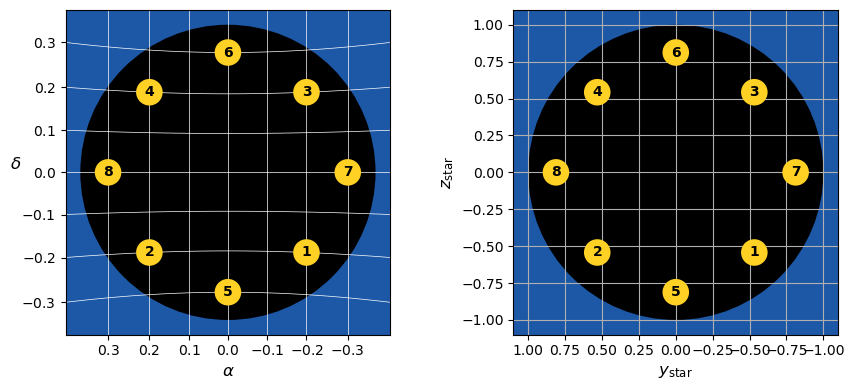

In [7]:
design.show_stars(stars)

Create a file with the location of stars. This will **overwrite** the file `stars.json` in the `urdf` directory.

In [8]:
design.create_stars(stars)

## Create dynamic model

Derive the equations of motion.

In [9]:
# Define yaw, pitch, roll angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                    [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                    [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right).$$

Here is the function $f$:

In [10]:
f

Matrix([
[                                                                                                                                                                             (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                                                                                                          w_y*cos(phi) - w_z*sin(phi)],
[                                                                                                                                                              w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-408248290463863*tau_1/12155468525000000 + 408248290463863*tau_2/24310937050000000 + 408248290463863*tau_3/24310937050000000 - 612323399573677*tau_4/243109370500000000000000000000000 + 542927038*w_y*w_z/2431093705],
[                                                                                                     -176776695296637*tau_

In [11]:
f_num = sym.lambdify([psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4],f)

#picking all eq points as zero satisfies reuquiremend of the dot terms to be zero too
psi_e = 0.
theta_e = 0.
phi_e = 0.
w_xe = 0.
w_ye = 0.
w_ze = 0.
tau_1e = 0.
tau_2e = 0.
tau_3e = 0.
tau_4e = 0.

m = sym.Matrix([psi,
                theta,
                phi,
                w_x,
                w_y,
                w_z
])

n = sym.Matrix([tau_1,
                tau_2,
                tau_3,
                tau_4
])

A_num = sym.lambdify([psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4],f.jacobian(m))
A = A_num(0,0,0,0,0,0,0,0,0,0)

B_num = sym.lambdify([psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4],f.jacobian(n))
B = B_num(0,0,0,0,0,0,0,0,0,0)


In [12]:
W = B
shape= A.shape[0]
for i in range(1,shape):
    col= np.linalg.matrix_power(A,i)@B
    W = np.block([[W,col]])
W = W.astype(np.float64)
rank = np.linalg.matrix_rank(W)
print(shape)
print(rank)

6
6


In [13]:
#finding K, but cant find u from here because of the sensor

import scipy.linalg
import control
m_e = sym.Matrix([psi_e,
                theta_e,
                phi_e,
                w_xe,
                w_ye,
                w_ze
])

n_e = sym.Matrix([tau_1e,
                tau_2e,
                tau_3e,
                tau_4e
])

x = m - m_e
u = n - n_e

Q = np.eye(6)
R = np.eye(4)

Q = np.diag([2, 1, 2, 1, 3, 1])  
R = np.diag([1,1,1,1])
K, _, _ = control.lqr(A, B, Q, R)

eigenvalues = np.linalg.eigvals(A - B @ K)
# Check if all eigenvalues are real (zero imaginary part) and have negative real part
if np.all(np.isclose(np.imag(eigenvalues), 0)) and np.all(np.real(eigenvalues) < 0):
    # Only print K and the eigenvalues if all eigenvalues are real with negative real part
    print("All eigenvalues are real with negative real parts.")
    print("LQR Gain Matrix K:")
    print(K)
    print("Closed-loop Eigenvalues:")
    print(eigenvalues)
else:
    print("Some eigenvalues have an imaginary part or positive real part.")



Some eigenvalues have an imaginary part or positive real part.


## Create sensor model

Create symbolic variables for right ascension $\alpha$ and declination $\delta$ of each star.

In [14]:
alpha, delta = sym.symbols('alpha, delta')

Derive the sensor model for one star.

In [15]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
r = sym.nsimplify(design.scope_radius)
p_star_in_image = (1 / r) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                        [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

The sensor model has the following form:

$$\begin{bmatrix} y_\text{star} \\ z_\text{star} \end{bmatrix} = g(\psi, \theta, \phi, \alpha, \delta).$$

Here is the function $g$:

In [16]:
g

Matrix([
[21*(sin(delta)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta)*cos(alpha - psi) + sin(alpha - psi)*cos(delta)*cos(phi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))],
[21*(sin(delta)*cos(phi)*cos(theta) - sin(phi)*sin(alpha - psi)*cos(delta) + sin(theta)*cos(delta)*cos(phi)*cos(alpha - psi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))]])

Again, this sensor model is for **one star only**. You will have to use a copy of this same model for each star you defined in the "Create Stars" section of this notebook.

In [17]:
# Create an empty list to store the sensor models for all stars
sensor_models = []

# Loop over each star in the stars list
for star in stars:
    alpha_val = star['alpha']
    delta_val = star['delta']
    
    # Position of star in space frame
    p_star_in_space = sym.Matrix([
        [sym.cos(alpha) * sym.cos(delta)],
        [sym.sin(alpha) * sym.cos(delta)],
        [sym.sin(delta)]
    ])
    
    # Orientation of body frame in space frame
    R_body_in_space = Rz * Ry * Rx
    
    # Position of star in body frame
    p_star_in_body = R_body_in_space.T * p_star_in_space
    
    # Position of star in image frame
    r = sym.nsimplify(design.scope_radius)  # Assuming design.scope_radius is defined
    p_star_in_image = (1 / r) * sym.Matrix([
        [p_star_in_body[1] / p_star_in_body[0]],
        [p_star_in_body[2] / p_star_in_body[0]]
    ])
    
    # Sensor model for current star
    g = sym.simplify(p_star_in_image, full=True)
    
    # Substitute the star's alpha and delta values
    g_substituted = g.subs({alpha: alpha_val, delta: delta_val})
    
    # Store the model
    sensor_models.append(g_substituted)

# sensor_models now contains the sensor models for all stars
# Stack all individual star sensor models into one vector
    g_total = sym.Matrix.vstack(*sensor_models)  # sensor_models contains all individual g's

g_total


Matrix([
[ 21*(0.980066577841242*sin(phi)*sin(theta)*cos(psi + 0.2) - 0.198669330795061*sin(phi)*cos(theta) - 0.980066577841242*sin(psi + 0.2)*cos(phi))/(8*(0.198669330795061*sin(theta) + 0.980066577841242*cos(theta)*cos(psi + 0.2)))],
[ 21*(0.980066577841242*sin(phi)*sin(psi + 0.2) + 0.980066577841242*sin(theta)*cos(phi)*cos(psi + 0.2) - 0.198669330795061*cos(phi)*cos(theta))/(8*(0.198669330795061*sin(theta) + 0.980066577841242*cos(theta)*cos(psi + 0.2)))],
[ 21*(0.980066577841242*sin(phi)*sin(theta)*cos(psi - 0.2) - 0.198669330795061*sin(phi)*cos(theta) - 0.980066577841242*sin(psi - 0.2)*cos(phi))/(8*(0.198669330795061*sin(theta) + 0.980066577841242*cos(theta)*cos(psi - 0.2)))],
[ 21*(0.980066577841242*sin(phi)*sin(psi - 0.2) + 0.980066577841242*sin(theta)*cos(phi)*cos(psi - 0.2) - 0.198669330795061*cos(phi)*cos(theta))/(8*(0.198669330795061*sin(theta) + 0.980066577841242*cos(theta)*cos(psi - 0.2)))],
[21*(0.980066577841242*sin(phi)*sin(theta)*cos(psi + 0.2) + 0.198669330795061*sin(p

In [18]:
g_num = sym.lambdify([psi,theta,phi],g_total)
C_num = sym.lambdify([psi,theta,phi],g_total.jacobian(m))
C = C_num(0,0,0)

y = C@x
Q_l = np.eye(6)
R_l = np.eye(16)

L, _, _ = control.lqr(A.T, C.T, Q_l, R_l)

# Transpose L to get the correct shape
L = L.T

print("Observer Gain Matrix L:")
print(L)
C.shape


Observer Gain Matrix L:
[[-0.39484498 -0.0159013  -0.39484498  0.0159013  -0.39484498  0.0159013
  -0.39484498 -0.0159013  -0.37926064 -0.         -0.37926064 -0.
  -0.41555168 -0.         -0.41555168 -0.        ]
 [ 0.01588721  0.39513489 -0.01588721  0.39513489 -0.01588721  0.39513489
   0.01588721  0.39513489  0.          0.41518344  0.          0.41518344
   0.          0.37892456  0.          0.37892456]
 [-0.33631685  0.32961291 -0.33631685 -0.32961291  0.33631685  0.32961291
   0.33631685 -0.32961291 -0.50299049 -0.          0.50299049 -0.
  -0.          0.50299049 -0.         -0.50299049]
 [-0.24405332  0.2391885  -0.24405332 -0.2391885   0.24405332  0.2391885
   0.24405332 -0.2391885  -0.36500252 -0.          0.36500252 -0.
   0.          0.36500252  0.         -0.36500252]
 [ 0.01416775  0.35236974 -0.01416775  0.35236974 -0.01416775  0.35236974
   0.01416775  0.35236974  0.          0.37024845 -0.          0.37024845
   0.          0.33791384  0.          0.33791384]
 [-0.35

(16, 6)

In [19]:
#observable?
import numpy as np

# Initialize observability matrix with the first row being C
W_c = C
shape = A.shape[0]  # Number of states

# Build the observability matrix iteratively
for i in range(1, shape):
    row = C @ np.linalg.matrix_power(A, i)
    W_c = np.block([[W_c], [row]])  # Stack new rows

# Convert to float for numerical stability
W_c = W_c.astype(np.float64)

# Compute rank
rank_O = np.linalg.matrix_rank(W_c)

# Print results
print("Number of states (n):", shape)
print("Rank of Observability Matrix:", rank_O)

if rank_O == shape:
    print("The system is OBSERVABLE.")
else:
    print("The system is NOT OBSERVABLE.")


Number of states (n): 6
Rank of Observability Matrix: 6
The system is OBSERVABLE.
